In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cmocean as cm
import cartopy.crs as ccrs

In [3]:
cd /g/data/tm70/ml0072/COMMON/git_repos/fork_access-eval-recipes/ml_create_own_datastore

/g/data/tm70/ml0072/COMMON/git_repos/fork_access-eval-recipes/ml_create_own_datastore


In [4]:
import sys
import os
import re
from matplotlib import pyplot as plt
from pprint import pprint
from intake import open_esm_datastore
import pandas as pd
import cftime
import cf_xarray
import xarray as xr
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
tool_dir = '/g/data/tm70/ml0072/COMMON/git_repos/fork_access-eval-recipes/ml_create_own_datastore'
sys.path.append(tool_dir)
from plot_functions import _expt_fullname, _read_ryaml, plot_time_series, plot2d, plot2d2

In [5]:
pics_folder = "send_to_gfdl"
pics_folder = os.path.join(tool_dir, pics_folder)
os.makedirs(pics_folder, exist_ok=True)

In [5]:
%load_ext autoreload
%autoreload 2

In [7]:
import sys
import os
from intake import open_esm_datastore
from ruamel.yaml import YAML
tool_dir = '/g/data/tm70/ml0072/COMMON/git_repos/fork_access-eval-recipes/ml_create_own_datastore'
sys.path.append(tool_dir)
from TruncationFilesReader import TruncationFilesReader
from dask.distributed import Client

ryaml = YAML()
ryaml.preserve_quotes = True

client = Client(threads_per_worker=1)
client

def _read_ryaml(yaml_path):
    """ Read yaml file and preserve comments"""
    with open(yaml_path, "r") as f:
        return ryaml.load(f)

expts_manager_path = '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager'
yamlfile_path = os.path.join(expts_manager_path, 'Expts_manager-025deg-75-layers.yaml')
yaml_input = _read_ryaml(yamlfile_path)
test_rel_path = yaml_input['test_path']
output_expt_path = os.path.join(expts_manager_path, test_rel_path)
intake_esm_ds = 'intake_esm_ds.json'
MOM_dirs = ['Ctrl-1deg_jra55do_ryf','epbl_1']  # directory names
MOM_names = ['KPP_ref', 'ePBL1-om5'] # user-defined names in this script
MOM_full_paths= [
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_0.25deg_new_topo/Ctrl-1deg_jra55do_ryf',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_0.25deg_new_topo/epbl_1'
]

datastore_tot = []
MOM_dirs_tot = []
MOM_dirs_path_tot = []
MOM_names_tot = []

for i,j,k in zip(MOM_dirs,MOM_names,MOM_full_paths):
    archive_path = os.path.join(f"{output_expt_path}",f"{i}","archive")
    datastore_path = os.path.join(f"{archive_path}",intake_esm_ds)
    if os.path.isfile(datastore_path):
        datastore = open_esm_datastore(datastore_path,columns_with_iterables=["variable"])
        datastore_tot.append(datastore)
        MOM_dirs_tot.append(f"{i}")
        MOM_dirs_path_tot.append(f"{k}")
        MOM_names_tot.append(f"{j}")

xarray_combine_by_coords_kwargs=dict(
    compat="override",
    data_vars="minimal",
    coords="minimal"
)

static = datastore_tot[0].search(path='.*output000.*',
                          frequency='fx'
                         ).to_dask(xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42037 instead
  warnings.warn(
INFO: State start
INFO:   Scheduler at:     tcp://127.0.0.1:42287
INFO:   dashboard at:        /proxy/42037/status
INFO: Registering Worker plugin shuffle
INFO:         Start Nanny at: 'tcp://127.0.0.1:36579'
INFO:         Start Nanny at: 'tcp://127.0.0.1:38309'
INFO: Register worker <WorkerState 'tcp://127.0.0.1:45693', name: 1, status: init, memory: 0, processing: 0>
INFO: Starting worker compute stream, tcp://127.0.0.1:45693
INFO: Starting established connection to tcp://127.0.0.1:55040
INFO: Register worker <WorkerState 'tcp://127.0.0.1:33347', name: 0, status: init, memory: 0, processing: 0>
INFO: Starting worker compute stream, tcp://127.0.0.1:33347
INFO: Starting established connection to tcp://127.0.0.1:55032
INFO: Receive 

In [15]:
archive_path = os.path.join(MOM_dirs_path_tot[0], 'archive')
truncation_reader = TruncationFilesReader(static, archive_path)
all_truncation_data = truncation_reader.process_truncation_files()
trunc_variable = 'trunc_month'
orgnised_data = truncation_reader.truncation_organise_by_variable(all_truncation_data, trunc_variable)

INFO: Available truncation keys: []


In [1]:
import os
import re
import logging
from datetime import datetime, timedelta
from collections import defaultdict

import numpy as np

logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

class TruncationFilesReader(object):
    """
    static: Dict[str, Any]: configuration static grid
    archive_path: str: path for an archive directory
    """
    def __init__(self, static, archive_path):
        self.static = static
        self.archive_path = archive_path
        self.xh, self.yh, self.geolon, self.geolat = load_coords(static)

    def load_coords(self):
        return self.static['xh'], self.static['yh'], self.static['geolon'], self.static['geolat']

    def process_truncation_files(self):
        all_truncation_data = []

        for output_dir in os.listdir(self.archive_path):
            output_dir_path = os.path.join(self.archive_path, output_dir)
            if os.path.isdir(output_dir_path) and output_dir.startswith('output'):
                for filename in os.listdir(output_dir_path):
                    if filename.startswith("U_velocity_truncations") or filename.startswith("V_velocity_truncations"):
                        truncation_files_path = os.path.join(output_dir_path, filename)
                        truncation_data = self.parse_truncation_files(truncation_files_path)
                        if truncation_data:
                            all_truncation_data.append(truncation_data)
        if not all_truncation_data:
            logging.warning(f"No velocity truncations exist in {archive_path}.")
        return all_truncation_data

    def parse_truncation_files(self):
        trunc_pattern = re.compile(
            r'Time\s+(\d+)\s+(\d+)\s+([\d.]+)\s+([UV])-velocity violation at\s+(\d+):\s+\d+\s+\d+\s+\(\s*([-+]?\d*\.\d+)\s+[E]?\s+([-+]?\d*\.\d+)\s+[N]?\)\s+Layers\s+(\d+)\s+to\s+(\d+)\.\s+dt\s+=\s+(\d+)'
        )
        truncations = []
    
        try:
            with open(self.truncation_files_path, 'r') as f:
                file_read = f.read()
            for match in trunc_pattern.finditer(file_read):
                truncations.append(_extract_truncation_data(match))
        except FileNotFoundError:
            logging.error(f"Files not found: {truncation_file_path}")
        except Exception as e:
            logging.error(f"Error processing file {truncation_file_path}: {e}")

    def _extract_truncation_data(self, match):
        year = int(match.group(1))
        yearday = int(match.group(2))
        time_of_day = float(match.group(3))
        velocity_type = match.group(4) + '-velocity'
        processor = int(match.group(5))
        lon = float(match.group(6))
        lat = float(match.group(7))
        layer_start = int(match.group(8))
        layer_end = int(match.group(9))
        dt = int(match.group(10))
        
        nearest_idx, nearest_lon_idx, nearest_lat_idx, nearest_lon, nearest_lat, nearest = self.find_indices(lon, lat)
        datetime_value = self.convert_to_date_time(year, yearday, time_of_day)
    
        return {
            'datetime': datetime_value,
            'velocity_type': velocity_type,
            'processor': processor,
            'longitude': lon,
            'latitude': lat,
            'longitude_index': nearest_lon_idx,
            'latitude_index': nearest_lat_idx,
            'eval_longitude': nearest_lon,
            'eval_latitude': nearest_lat,
            'layers_start': layer_start,
            'layers_end': layer_end,
            'dt': dt,
        }

    def find_indices(self, target_lon, target_lat):
    
        if hasattr(self.xh, 'values'):
            xh = self.xh.values
        if hasattr(self.xh, 'values'):
            yh = self.xh.values
    
        lon_diff = np.abs(xh - target_lon)
        lat_diff = np.abs(yh - target_lat)
    
        nearest_lon_idx = np.argmin(lon_diff)
        nearest_lat_idx = np.argmin(lat_diff)
        return (
            (nearest_lat_idx, nearest_lon_idx),
            nearest_lon_idx, nearest_lat_idx,
            xh[nearest_lon_idx], yh[nearest_lat_idx],
            (yh[nearest_lat_idx], xh[nearest_lon_idx])
        )

    def convert_to_date_time(self, year, yearday, time):
        yearday = max(1, yearday)
        tmp = datetime(year, 1, 1)
        target_date = tmp + timedelta(days=yearday-1)
        
        hours = int(time)
        minutes = int((time-hours)*60)
        seconds = int((((time-hours)*60)-minutes)*60)
        return target_date + timedelta(hours=hours, minutes=minutes, seconds=seconds)

    def truncation_organise_by_variable(self, truncation_data, trunc_variable):
        group_data = defaultdict(list)
        for trunc in truncation_data:
            if trunc_variable == 'trunc_month':
                v = trunc['datetime'].month
            elif trunc_variable == 'trunc_year':
                v = trunc['datetime'].year
            else:
                v = trunc.get(trunc_variable)
            group_data[v].append(trunc)
        return dict(group_data)



In [45]:
import os
import re
import logging
from datetime import datetime, timedelta
from collections import defaultdict
from typing import List, Dict, Tuple, Any

import numpy as np

logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

def load_coords(static: Dict[str, Any]) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    return static['xh'], static['yh'], static['geolon'], static['geolat']
    
def process_truncation_files(target_dir: str, static: Dict[str, Any]) -> \
    Tuple[List[Dict], np.ndarray, np.ndarray,np.ndarray,np.ndarray]:

    all_truncation_data = []
    xh, yh, geolon, geolat = load_coords(static)

    for output_dir in os.listdir(target_dir):
        output_dir_path = os.path.join(target_dir, output_dir)
        if os.path.isdir(output_dir_path) and output_dir.startswith('output'):
            for filename in os.listdir(output_dir_path):
                if filename.startswith("U_velocity_truncations") or filename.startswith("V_velocity_truncations"):
                    truncation_file_path = os.path.join(output_dir_path, filename)
                    truncation_data = parse_truncation_file(truncation_file_path, xh, yh)
                    if truncation_data:
                        all_truncation_data.append(truncation_data)
    if not all_truncation_data:
        logging.warning(f"No velocity truncations exist in {target_dir}.")
    return all_truncation_data, xh, yh, geolon, geolat

def parse_truncation_file(truncation_file_path: str, xh: np.ndarray, yh: np.ndarray) -> List[Dict]:
    trunc_pattern = re.compile(
        r'Time\s+(\d+)\s+(\d+)\s+([\d.]+)\s+([UV])-velocity violation at\s+(\d+):\s+\d+\s+\d+\s+\(\s*([-+]?\d*\.\d+)\s+[E]?\s+([-+]?\d*\.\d+)\s+[N]?\)\s+Layers\s+(\d+)\s+to\s+(\d+)\.\s+dt\s+=\s+(\d+)'
    )
    truncations = []

    try:
        with open(truncation_file_path, 'r') as f:
            file_read = f.read()
        for match in trunc_pattern.finditer(file_read):
            truncations.append(_extract_truncation_data(match, xh, yh))
    except FileNotFoundError:
        logging.error(f"File not found: {truncation_file_path}")
    except Exception as e:
        logging.error(f"Error processing file {truncation_file_path}: {e}")

def _extract_truncation_data(match: re.match, xh: np.ndarray, yh: np.ndarray) -> Dict:
    year = int(match.group(1))
    yearday = int(match.group(2))
    time_of_day = float(match.group(3))
    velocity_type = match.group(4) + '-velocity'
    processor = int(match.group(5))
    lon = float(match.group(6))
    lat = float(match.group(7))
    layer_start = int(match.group(8))
    layer_end = int(match.group(9))
    dt = int(match.group(10))
    
    nearest_idx, nearest_lon_idx, nearest_lat_idx, nearest_lon, nearest_lat, nearest = find_indices_based_on_xh_yh(lon, lat, xh, yh)
    datetime_value = convert_to_date_time(year, yearday, time_of_day)

    return {
        'datetime': datetime_value,
        'velocity_type': velocity_type,
        'processor': processor,
        'longitude': lon,
        'latitude': lat,
        'longitude_index': nearest_lon_idx,
        'latitude_index': nearest_lat_idx,
        'eval_longitude': nearest_lon,
        'eval_latitude': nearest_lat,
        'layers_start': layer_start,
        'layers_end': layer_end,
        'dt': dt,
    }

def find_indices_based_on_xh_yh(target_lon: float, target_lat: float, xh: np.ndarray, yh: np.ndarray) ->\
Tuple[Tuple[int, int], int, int, float, float, Tuple[float, float]]:

    if hasattr(xh, 'values'):
        xh = xh.values
    if hasattr(yh, 'values'):
        yh = yh.values

    lon_diff = np.abs(xh - target_lon)
    lat_diff = np.abs(yh - target_lat)

    nearest_lon_idx = np.argmin(lon_diff)
    nearest_lat_idx = np.argmin(lat_diff)
    return (
        (nearest_lat_idx, nearest_lon_idx),
        nearest_lon_idx, nearest_lat_idx,
        xh[nearest_lon_idx], yh[nearest_lat_idx],
        (yh[nearest_lat_idx], xh[nearest_lon_idx])
    )

def convert_to_date_time(year: int, yearday: int, time: float) -> datetime:
    yearday = max(1, yearday)
    tmp = datetime(year, 1, 1)
    target_date = tmp + timedelta(days=yearday-1)
    
    hours = int(time)
    minutes = int((time-hours)*60)
    seconds = int((((time-hours)*60)-minutes)*60)
    return target_date + timedelta(hours=hours, minutes=minutes, seconds=seconds)

def truncation_organise_by_variable(truncation_data: List[Dict], trunc_variable: str) -> Dict:
    group_data = defaultdict(list)
    for trunc in truncation_data:
        for i in trunc:
            if trunc_variable == 'trunc_month':
                v = i['datetime'].month
            elif trunc_variable == 'trunc_year':
                v = i['datetime'].year
            else:
                v = i[trunc_variable] if trunc_variable in i else None
            group_data[v].append(i)
    return dict(group_data)

In [46]:
truncation_data, xh, yh, _, _ = process_truncation_files(os.path.join(MOM_dirs_path_tot[0], 'archive'), static)
trunc_variable = 'trunc_month'
group_data = truncation_organise_by_variable(truncation_data, trunc_variable)
trunc_keys = list(group_data.keys())
logging.info(f"Available truncation keys: {list(group_data.keys())}")

INFO:root:Available truncation keys: []


In [31]:
fields = ['T_adx_2d','tauuo']
data = { k: datastore.search(variable=k, frequency='1mon', variable_cell_methods='.*time: mean.*').to_dask(
    xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs) for k in fields }
data

{'T_adx_2d': <xarray.Dataset> Size: 158MB
 Dimensions:   (time: 24, yh: 1142, xq: 1440)
 Coordinates:
   * xq        (xq) float64 12kB -279.8 -279.5 -279.2 -279.0 ... 79.5 79.75 80.0
   * yh        (yh) float64 9kB -80.94 -80.87 -80.81 -80.74 ... 89.74 89.84 89.95
   * time      (time) object 192B 1900-01-16 12:00:00 ... 1901-12-16 12:00:00
 Data variables:
     T_adx_2d  (time, yh, xq) float32 158MB dask.array<chunksize=(1, 1142, 1440), meta=np.ndarray>
 Attributes: (12/15)
     NumFilesInSet:                            1
     title:                                    ACCESS-OM3
     grid_type:                                regular
     grid_tile:                                N/A
     intake_esm_vars:                          ['T_adx_2d']
     intake_esm_attrs:realm:                   ocean
     ...                                       ...
     intake_esm_attrs:variable_standard_name:  ['', '', '', '', '']
     intake_esm_attrs:variable_cell_methods:   ['yh:sum xq:point time: mean

all indices: [[-1]]
total subplots: 1 for 2d plots
0 -1


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/pydantic/deprecated/decorator.py:222: UserWarning: There are no datasets to load! Returning an empty dictionary.
  return self.raw_function(**d, **var_kwargs)


ValueError: must supply at least one object to concatenate

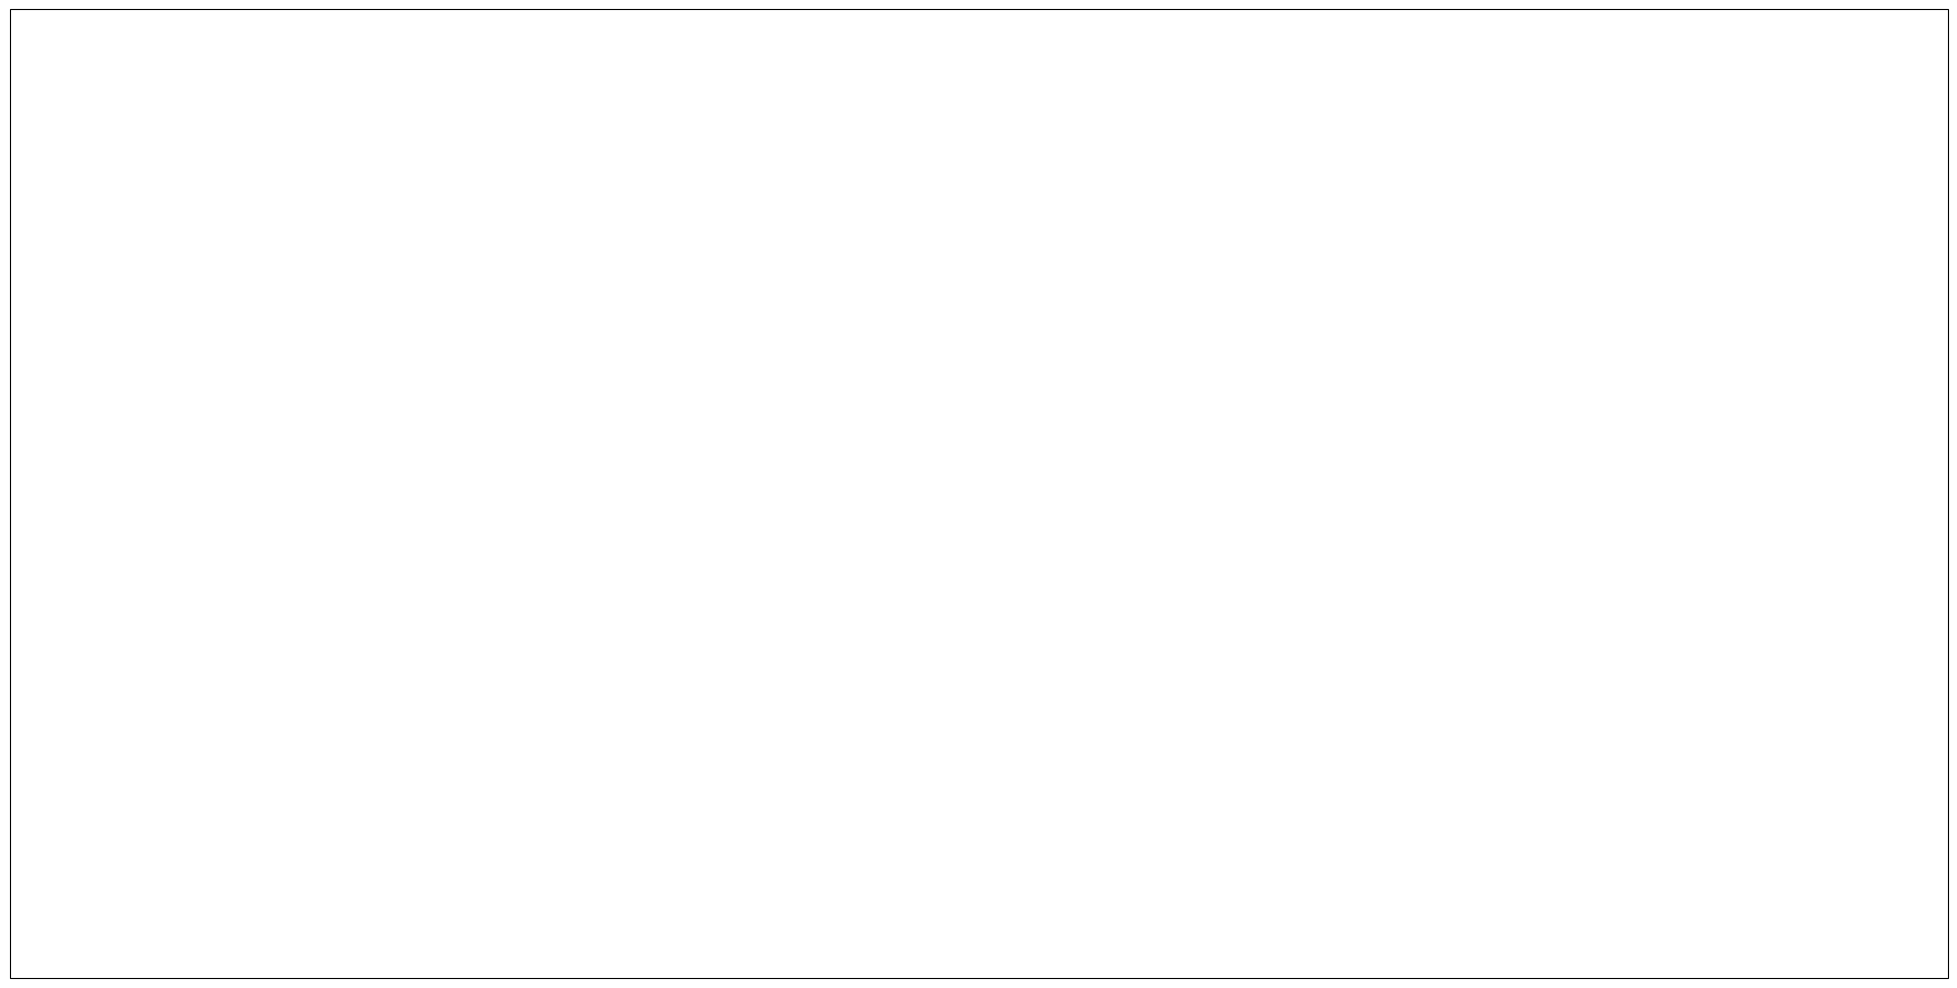

In [12]:
%%time
plots_config = [
            {
             'indices': [-1],
            },
           ]
plot2d2(datastore_tot,MOM_names_tot,
                data_collect_method='mean',
                plots_config=plots_config,
                figsize=(25,15),
                cmap = 'cividis',
                time_selection = 'date_slice',
                time_range = ['1900-01-01', '1904-01-01'],
                yincrease = True,
                truncation_errors=True, trunc_variable='trunc_month', trunc_plot=None, MOM_dirs_path_tot = MOM_dirs_path_tot,
                project_ccrs=True, geo_plot=True, levels=33, title_fontsize=15,
                )
plt.tight_layout()

all indices: [[0, -1, -2]]
total subplots: 3 for 2d contourf plots
0 0
processing truncation error files...
available trunc_keys: [1, 10, 12]
plots@@@
1
'lon_indices: [889, 888, 889, 888, 903, 904, 905, 906, 907, 903, 904, 905, 906]'
'lat_indices: [778, 780, 780, 780, 768, 768, 768, 768, 768, 767, 767, 767, 767]'
('datetime: [datetime.datetime(1900, 1, 1, 2, 48, 36), datetime.datetime(1900, '
 '1, 1, 2, 48, 36), datetime.datetime(1900, 1, 1, 2, 48, 36), '
 'datetime.datetime(1900, 1, 1, 2, 48, 36), datetime.datetime(1900, 1, 1, 2, '
 '48, 36), datetime.datetime(1900, 1, 1, 2, 48, 36), datetime.datetime(1900, '
 '1, 1, 2, 48, 36), datetime.datetime(1900, 1, 1, 2, 48, 36), '
 'datetime.datetime(1900, 1, 1, 2, 48, 36), datetime.datetime(1900, 1, 1, 2, '
 '48, 36), datetime.datetime(1900, 1, 1, 2, 48, 36), datetime.datetime(1900, '
 '1, 1, 2, 48, 36), datetime.datetime(1900, 1, 1, 2, 48, 36)]')
('lon: [-57.62, -57.88, -57.62, -57.88, -54.0, -53.75, -53.5, -53.25, -53.0, '
 '-54.0, -53.75, 

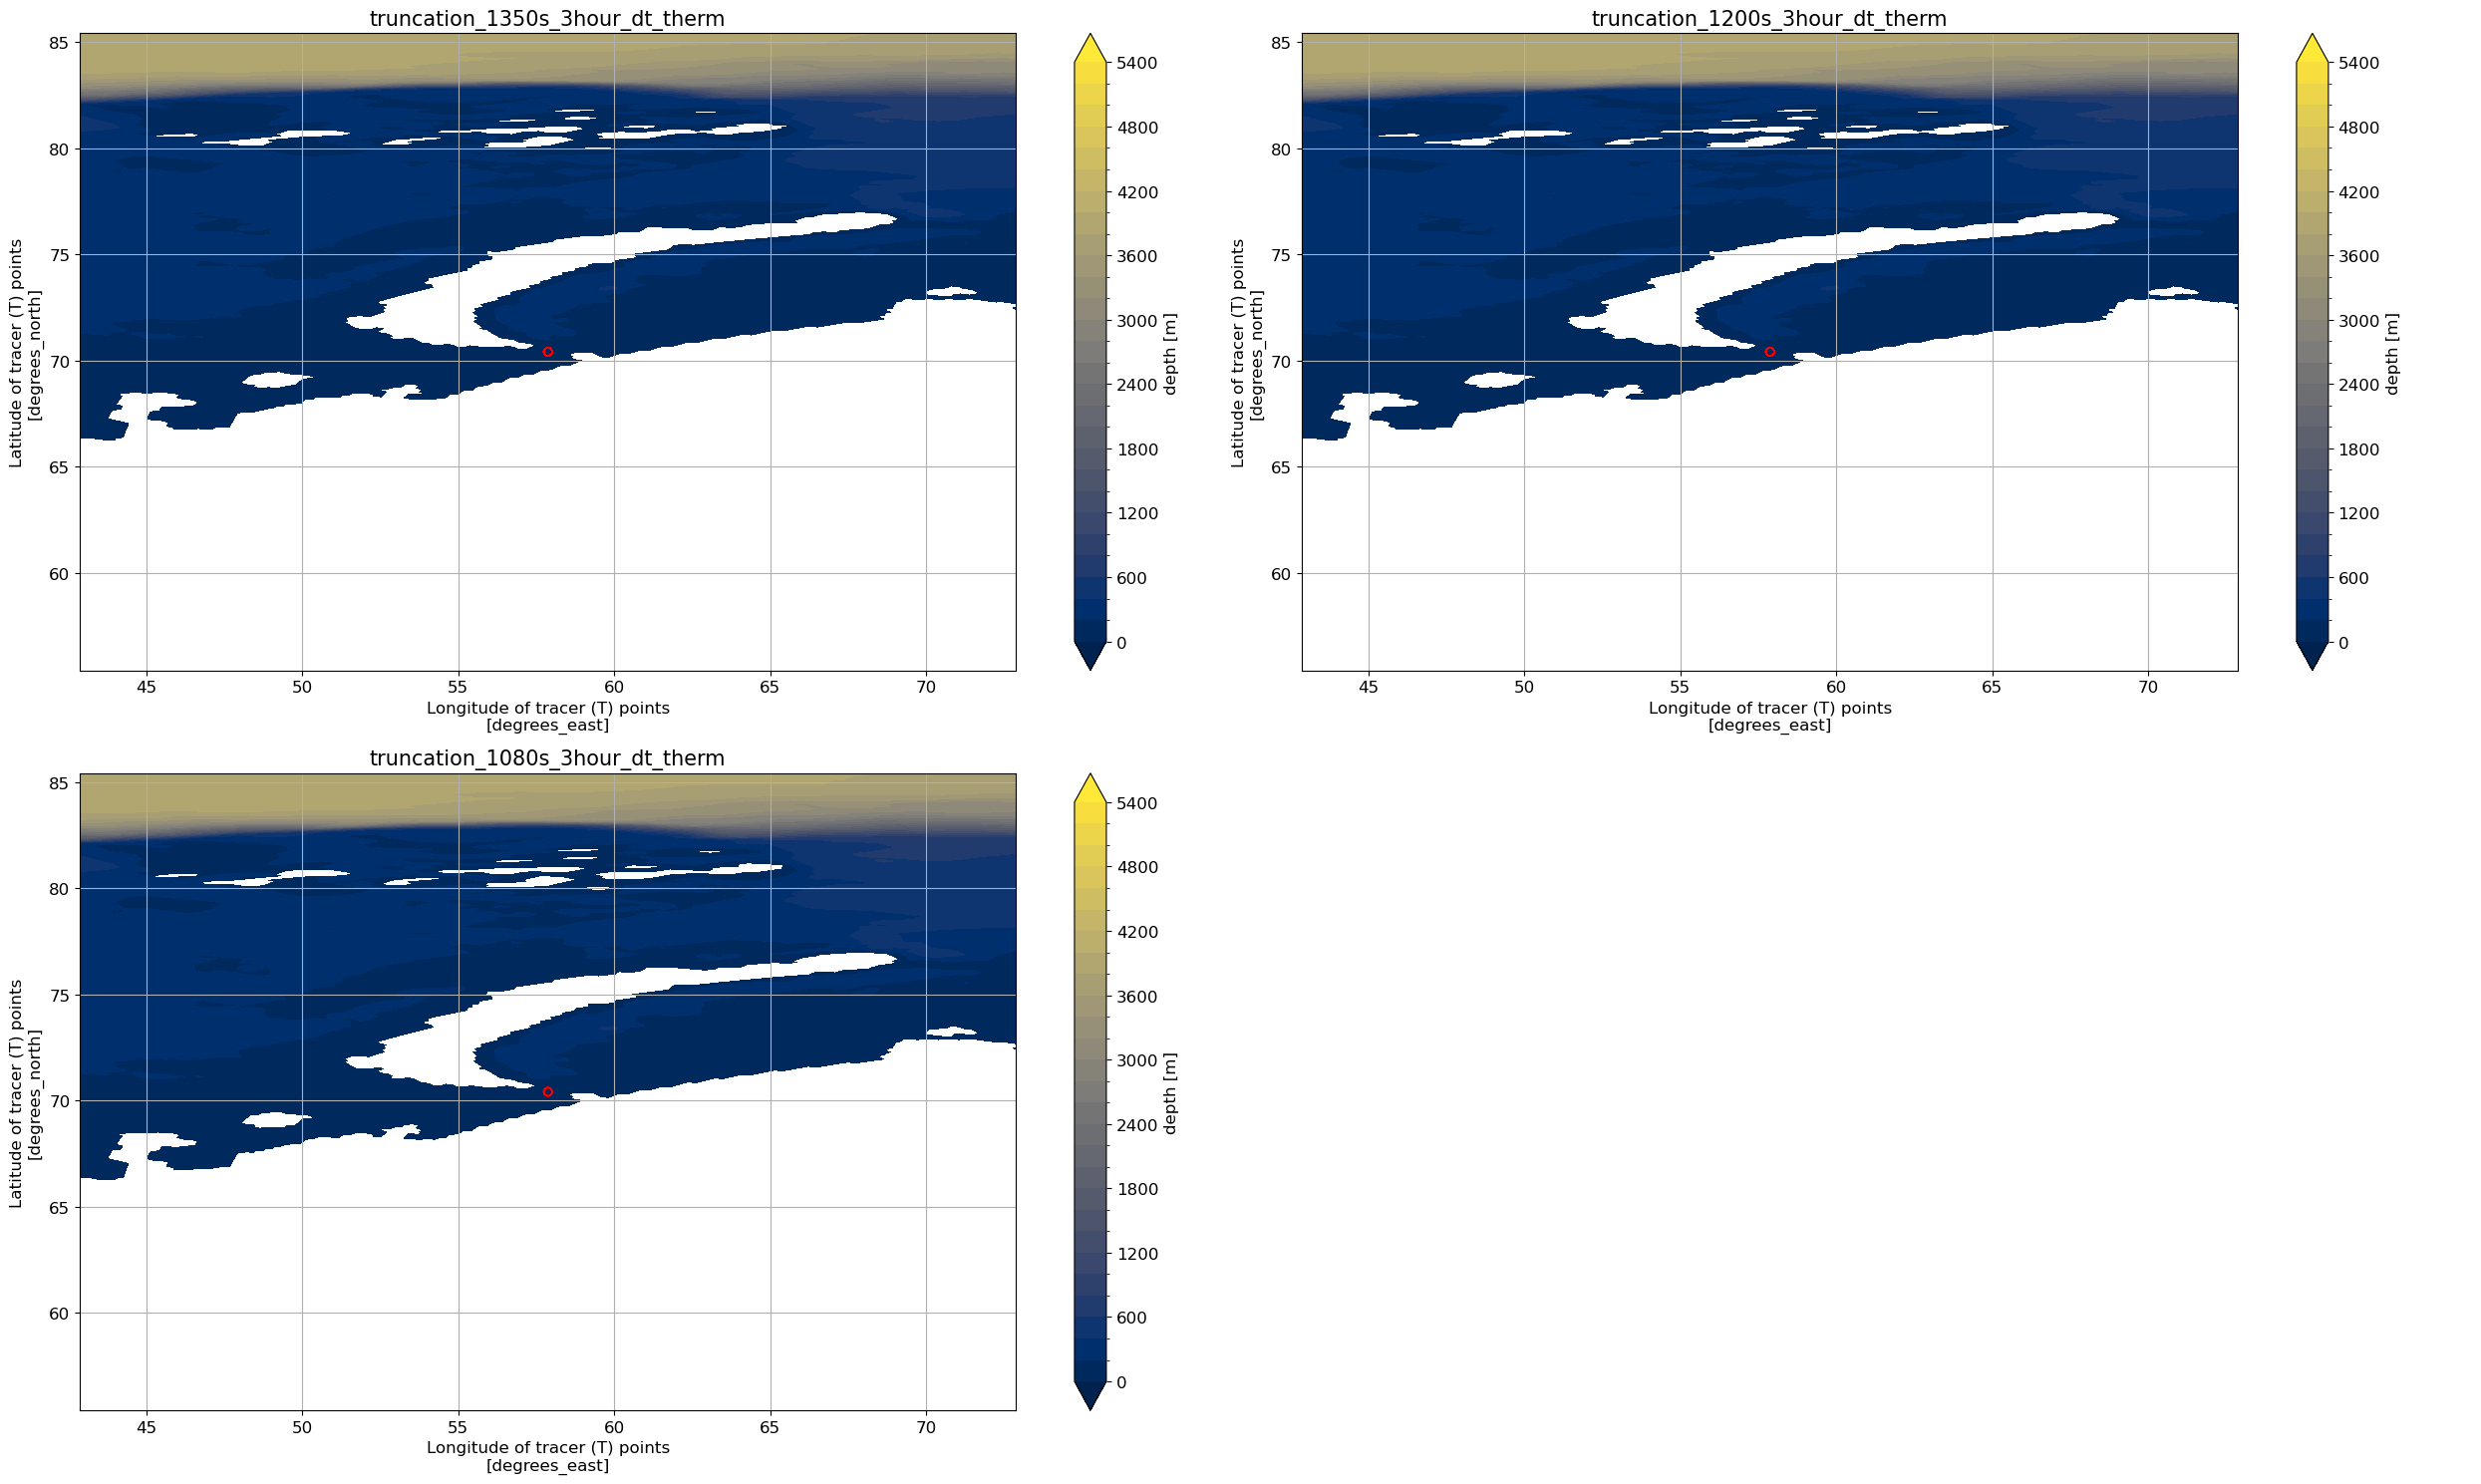

CPU times: user 7.69 s, sys: 207 ms, total: 7.89 s
Wall time: 8.16 s


In [41]:
%%time
zoom_in=15
plots_config = [
            {'var':'thetao', # dummy variable for truncation plots
             'indices': [0,-1,-2],
             'xlims': [57.875-zoom_in, 57.875+zoom_in],
             'ylims': [70.41154332-zoom_in, 70.41154332+zoom_in]
            },
           ]
plot2d2(datastore_tot,MOM_names_tot,
                data_collect_method='mean',
                plots_config=plots_config,
                figsize=(25,15),
                cmap = 'cividis',
                time_selection = 'date_slice',
                time_range = ['1900-01-01', '1904-01-01'],
                yincrease = True,
                truncation_errors=True, trunc_variable='trunc_month', trunc_plot=None, MOM_dirs_path_tot = MOM_dirs_path_tot,
                project_ccrs=False, geo_plot=True, levels=33, title_fontsize=15,
                )
plt.tight_layout()
pic_name = "truncation_locations"
file_path = os.path.join(pics_folder, pic_name+ ".png")
plt.savefig(file_path,dpi=400)
plt.show()

all indices: [[0, -1, -2]]
total subplots: 3 for 2d contourf plots
0 0
processing truncation error files...
available trunc_keys: [1, 10, 12]
plots@@@
1
'lon_indices: [889, 888, 889, 888, 903, 904, 905, 906, 907, 903, 904, 905, 906]'
'lat_indices: [778, 780, 780, 780, 768, 768, 768, 768, 768, 767, 767, 767, 767]'
('datetime: [datetime.datetime(1900, 1, 1, 2, 48, 36), datetime.datetime(1900, '
 '1, 1, 2, 48, 36), datetime.datetime(1900, 1, 1, 2, 48, 36), '
 'datetime.datetime(1900, 1, 1, 2, 48, 36), datetime.datetime(1900, 1, 1, 2, '
 '48, 36), datetime.datetime(1900, 1, 1, 2, 48, 36), datetime.datetime(1900, '
 '1, 1, 2, 48, 36), datetime.datetime(1900, 1, 1, 2, 48, 36), '
 'datetime.datetime(1900, 1, 1, 2, 48, 36), datetime.datetime(1900, 1, 1, 2, '
 '48, 36), datetime.datetime(1900, 1, 1, 2, 48, 36), datetime.datetime(1900, '
 '1, 1, 2, 48, 36), datetime.datetime(1900, 1, 1, 2, 48, 36)]')
('lon: [-57.62, -57.88, -57.62, -57.88, -54.0, -53.75, -53.5, -53.25, -53.0, '
 '-54.0, -53.75, 

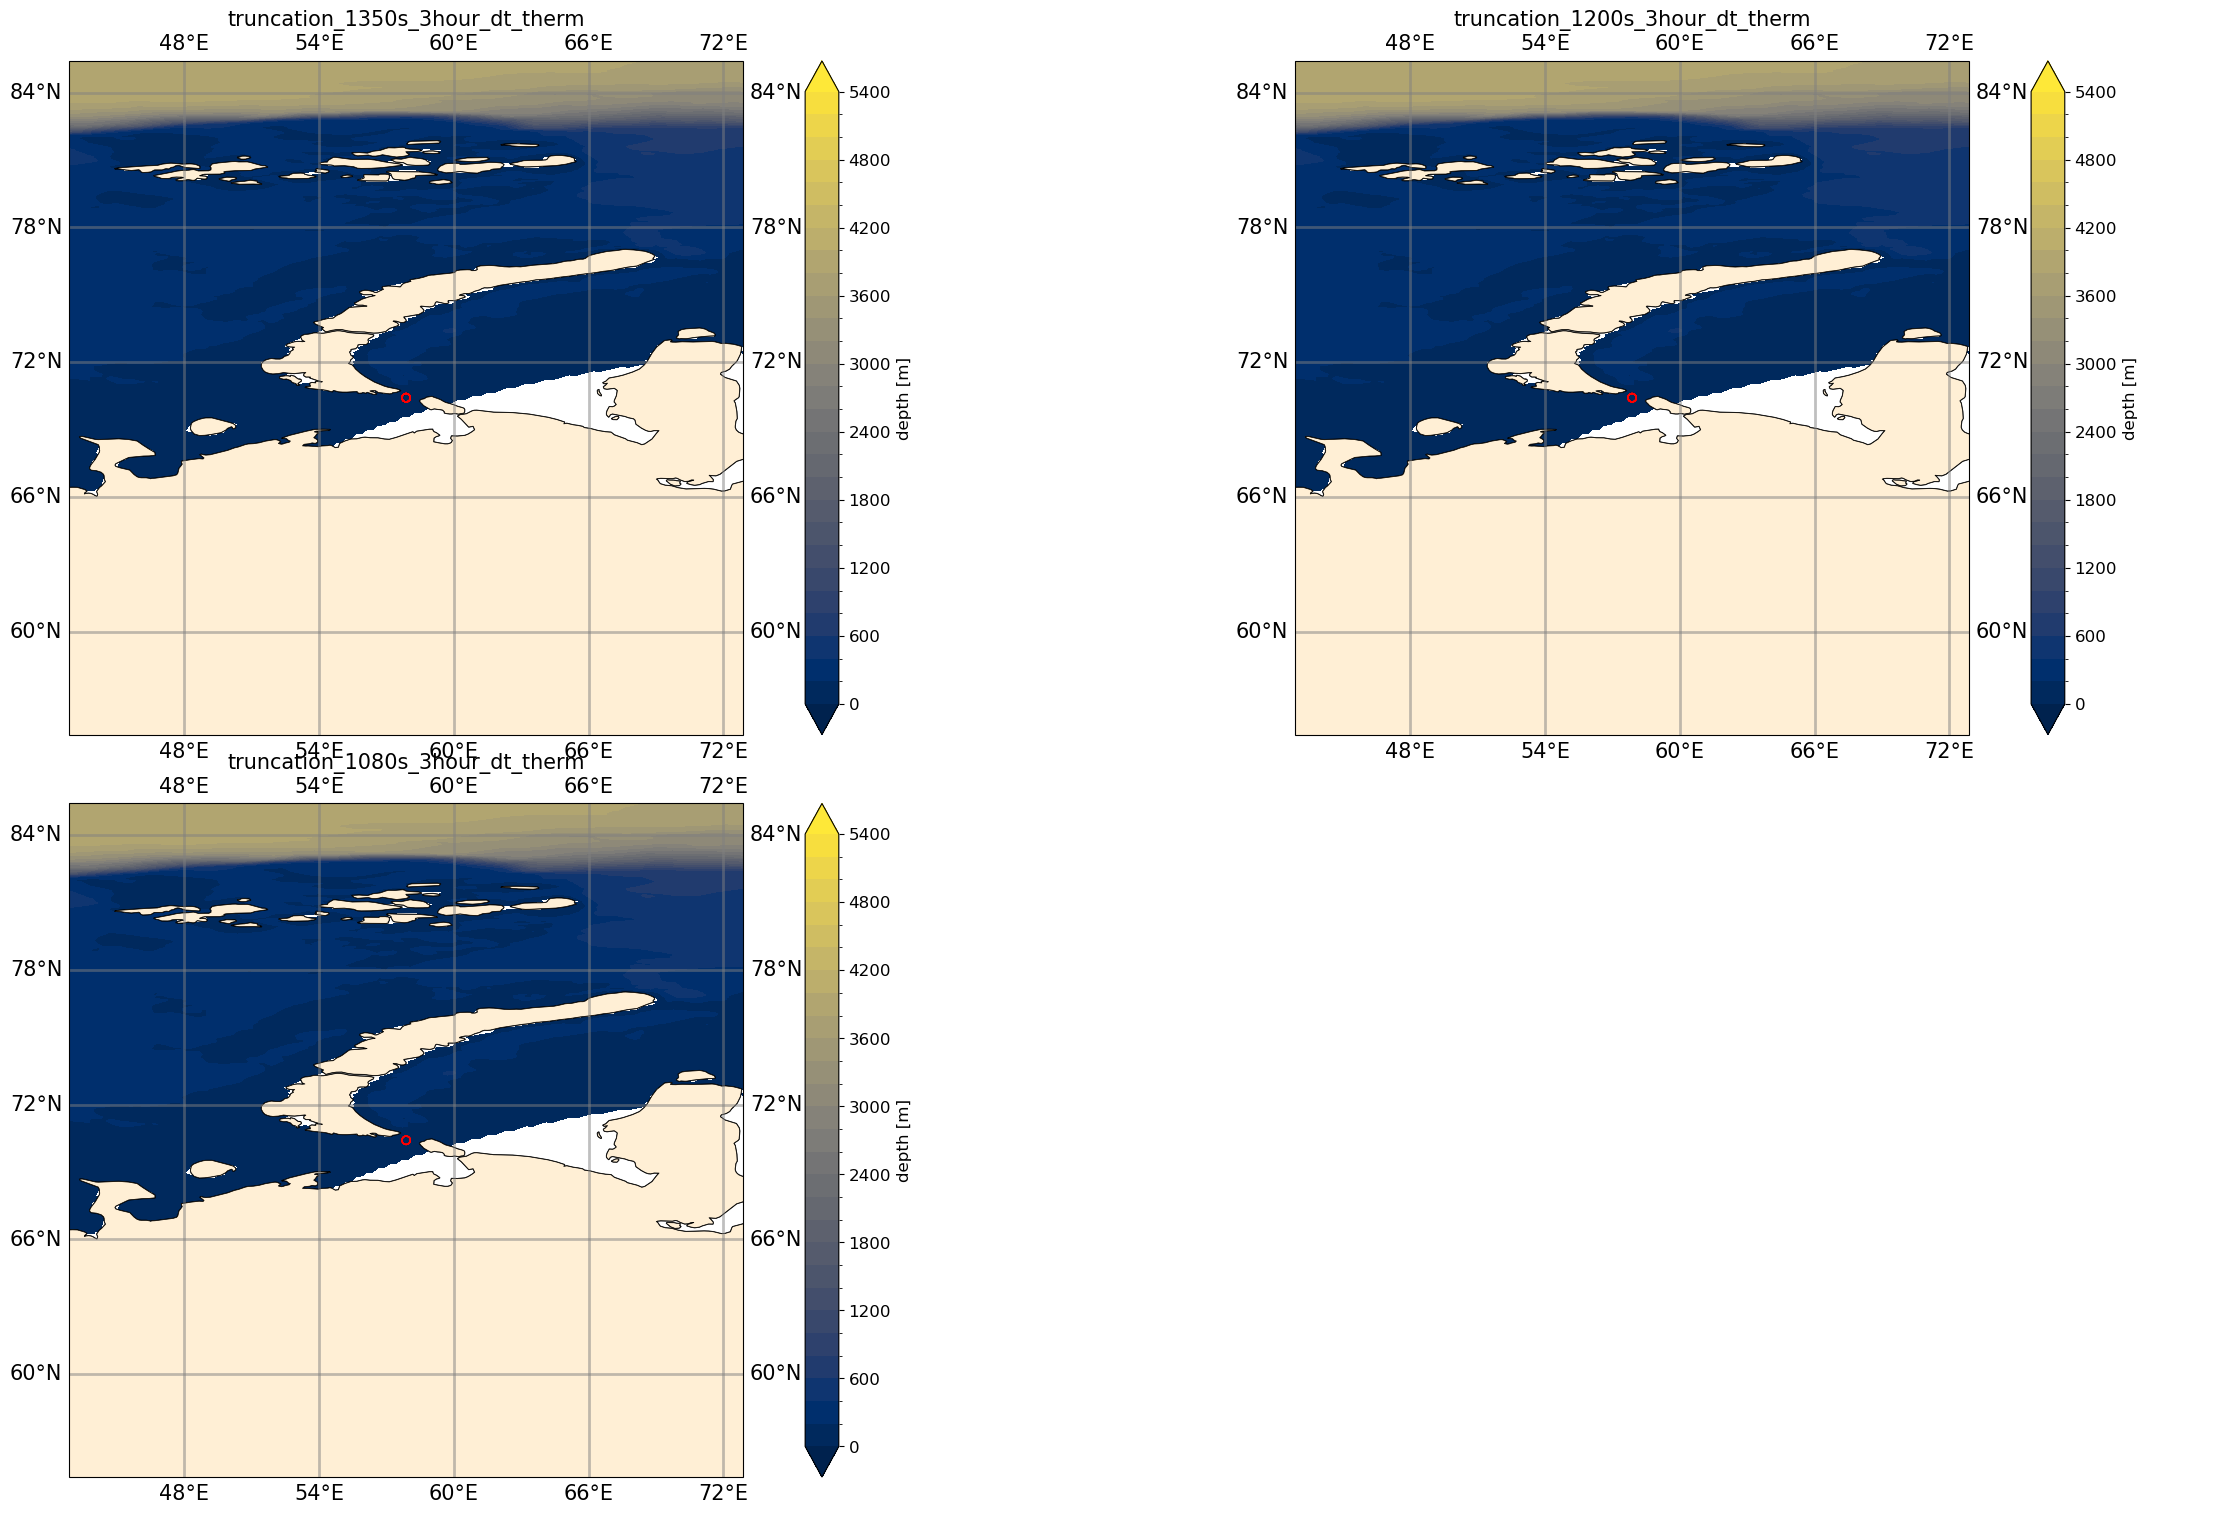

CPU times: user 9min 32s, sys: 676 ms, total: 9min 33s
Wall time: 9min 33s


In [40]:
%%time
zoom_in=15
plots_config = [
            {'var':'thetao', # dummy variable for truncation plots
             'indices': [0,-1,-2],
             'xlims': [57.875-zoom_in, 57.875+zoom_in],
             'ylims': [70.41154332-zoom_in, 70.41154332+zoom_in]
            },
           ]
plot2d2(datastore_tot,MOM_names_tot,
                data_collect_method='mean',
                plots_config=plots_config,
                figsize=(25,15),
                cmap = 'cividis',
                time_selection = 'date_slice',
                time_range = ['1900-01-01', '1904-01-01'],
                yincrease = True,
                truncation_errors=True, trunc_variable='trunc_month', trunc_plot=None, MOM_dirs_path_tot = MOM_dirs_path_tot,
                project_ccrs=True, geo_plot=True, levels=33, title_fontsize=15,
                )
plt.tight_layout()
pic_name = "truncation_locations_ccrs_geo_plot"
file_path = os.path.join(pics_folder, pic_name+ ".png")
plt.savefig(file_path,dpi=400)
plt.show()

0
processing truncation error files...
available trunc_keys: [1, 10, 12]
1
'lon_indices: [894, 889, 894, 889, 904, 905, 906, 907, 908, 904, 905, 906, 907]'
'lat_indices: [779, 780, 780, 781, 769, 769, 769, 769, 769, 768, 768, 768, 768]'
('datetime: [datetime.datetime(1900, 1, 1, 2, 48, 36), datetime.datetime(1900, '
 '1, 1, 2, 48, 36), datetime.datetime(1900, 1, 1, 2, 48, 36), '
 'datetime.datetime(1900, 1, 1, 2, 48, 36), datetime.datetime(1900, 1, 1, 2, '
 '48, 36), datetime.datetime(1900, 1, 1, 2, 48, 36), datetime.datetime(1900, '
 '1, 1, 2, 48, 36), datetime.datetime(1900, 1, 1, 2, 48, 36), '
 'datetime.datetime(1900, 1, 1, 2, 48, 36), datetime.datetime(1900, 1, 1, 2, '
 '48, 36), datetime.datetime(1900, 1, 1, 2, 48, 36), datetime.datetime(1900, '
 '1, 1, 2, 48, 36), datetime.datetime(1900, 1, 1, 2, 48, 36)]')
('lon: [-57.62, -57.88, -57.62, -57.88, -54.0, -53.75, -53.5, -53.25, -53.0, '
 '-54.0, -53.75, -53.5, -53.25]')
('lat: [57.29, 57.43, 57.43, 57.56, 55.85, 55.85, 55.85, 55.8

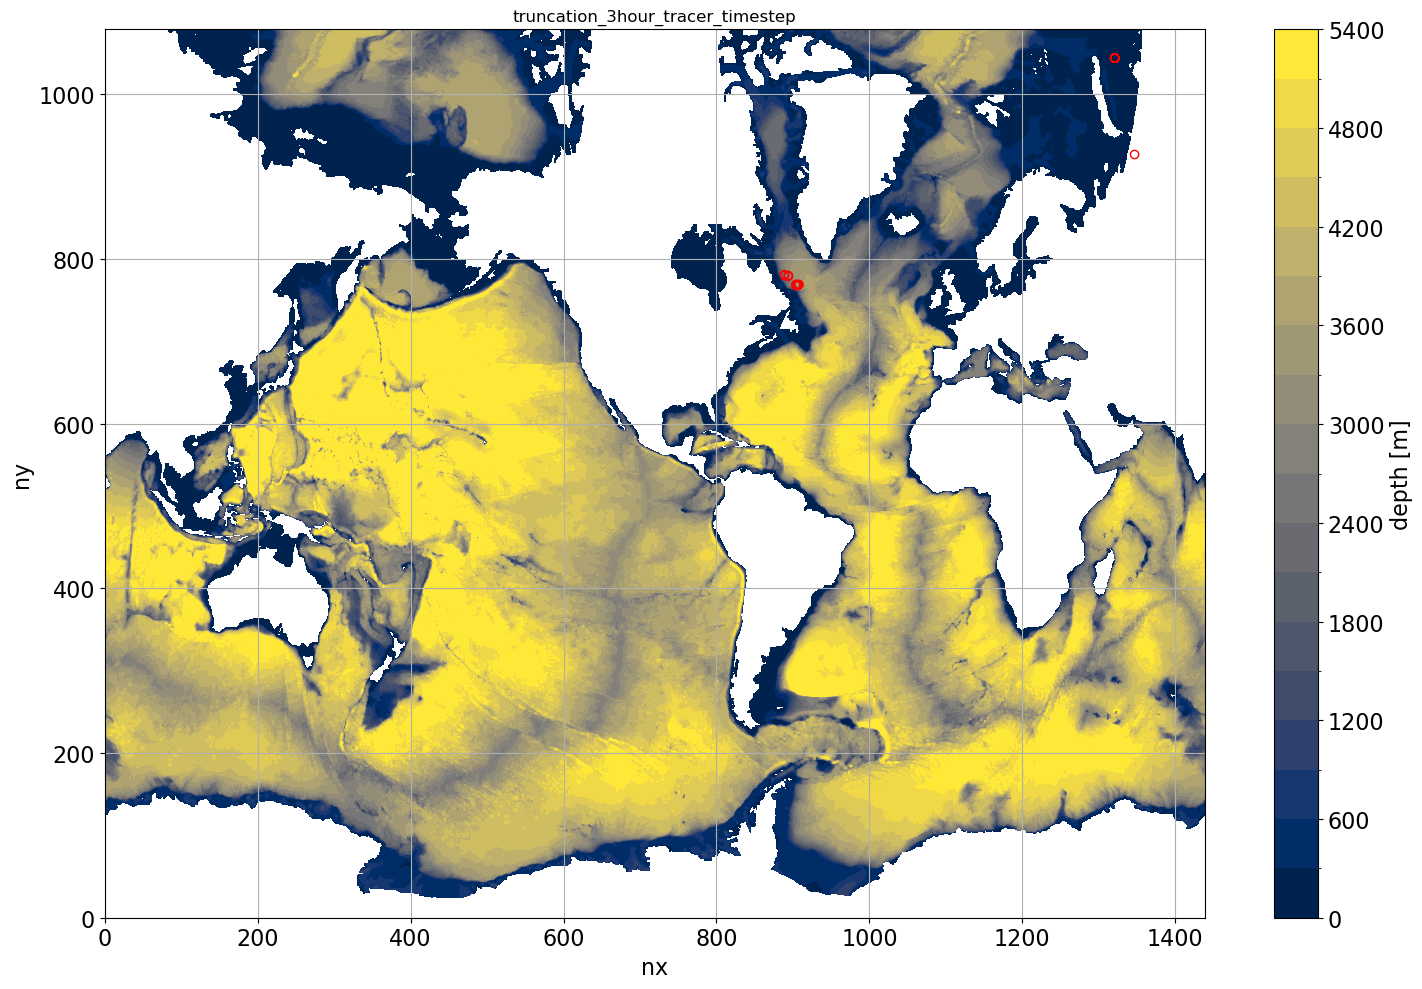

In [26]:
%%time
var = 'umo'
tmp_indx = [0]
datastore_expts = [datastore_tot[i] for i in tmp_indx]
MOM_names_expts = [MOM_names_tot[i] for i in tmp_indx]
plot2d(datastore_expts,
        MOM_names_expts,
        var,
        time_selection = 'date_slice',
        start_time = '1900-01-01',
        end_time = '1900-01-01',
        ncols=1,
        figsize=(15,10),
        cmap = 'cividis',
        yincrease = True,
        truncation_errors=True, trunc_variable='trunc_month', trunc_plot=None, MOM_dirs_path_tot = MOM_dirs_path_tot,
        xlims=None, ylims=None,
      )
plt.tight_layout()